<a href="https://colab.research.google.com/github/RusAl84/IntroML/blob/master/2_1_%D0%A1%D1%82%D0%B5%D0%BA%D0%B8%D0%BD%D0%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ансамбли. Стекинг
Еще один вариант ансамблей - стекинг - когда объединяются результаты разнородных моделей с помощью еще одной модели.
В `sklearn` реализованы
* [`StackingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier)  - классификатор
* [`StackingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html#sklearn.ensemble.StackingRegressor) - регрессор

Аргументы для создания ансамблей:
* `estimators` - кортеж из названий и объектов моделей ансамбля
* `final_estimator` - модель для объединения результатов, по умолчанию `LogisticRegression` для классификатора и `RidgeCV` для регрессора.
* `cv` - число разбиений для кроссвалидации (или объекты)
* `stack_method` - по какому именно результату объединять модели: ‘auto’, ‘predict_proba’, ‘decision_function’, ‘predict’,
* `verbose` - число, определяющее как подробно выводить информацию об обучении, по умолчанию 0 - не выводить
* `passthrough` - использовать ли для обучения финальной модели сами данные или только результаты моделей ансамбля.

Создаваемые модели имеют атрибуты

* `estimators_` - список обученных моделей в ансамбле
* `final_estimator_` - обученная финальная модель
* `named_estimators_` - контейнер для доступа к параметрам моделей по их названию
* `classes_` - для классификатора метки классов

Реализованные методы аналогичны: `fit()`, `pedict()`, ...

Реализованы также  [`VotingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) и [`VotingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html#sklearn.ensemble.VotingRegressor), отличающиеся тем, что в качестве финальной модели используется процедура голосования.



In [ ]:
# функция  для рисования разделяющей поверхности на плоскости

# Div_plate(clf,flip_level) принимает объект-классификатор и уровень шума (ошибок)
# создает двумерные данные, обучает классификатор, рисует разделяющую поверхность
# Классификация с шумом
def Div_plate(clf, flip_level):
    from sklearn.datasets import make_classification # для генерации данных
    from sklearn.model_selection import train_test_split # для разделения на обучение и тест
    import numpy as np
    import seaborn as sns # для простого отображения
    import matplotlib.pyplot as plt #
    # создаем данные
    X,y = make_classification(n_samples=10000, # число примеров
                              n_features=2, # число признаков (атрибутов)
                              n_informative=2, # из них информативных
                              n_redundant=0, # из них не информативных
                              n_repeated=0, # из них повторяющихся
                              n_classes=2, # число классов
                              n_clusters_per_class=1, # число кластеров на класс
                              class_sep=2, # влияет на расстояние между кластерами
                              flip_y=flip_level, # доля ошибок (шума)
                              weights=[0.5,0.5], # пропорции числа данных в классах
                              random_state=17) #

    # разделяем на обучающие и тестовые, случайно
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)
    # рисуем данные
    plt.subplots();#
    ax1=plt.gca();#
    sns.scatterplot(X_train[:,0],X_train[:,1],hue=y_train,ax=ax1);# обучающие
    sns.scatterplot(X_test[:,0],X_test[:,1],hue=y_test,ax=ax1,marker="+");# тестовые
    ax1.set_title("Data With Noise");#
    plt.show();#
    # Создаем классификатор на основе случайного леса. Изменяйте параметры и смотрите как это влияет на обучение
    clf.fit(X_train, y_train) # обучаем
    y_pred = clf.predict(X_test) # проверяем на тесттовых данных
    score=clf.score(X_test, y_test) # считаем среднюю точность
    print('Score=',score)
    ind=y_test==y_pred; # индексы совпадений результата классификации и меток классов
    plt.subplots();
    ax2=plt.gca();
    # рисуем "правильно" распознанные примеры
    sns.scatterplot(X_test[ind,0],X_test[ind,1],hue=y_test[ind],ax=ax2);
    # рисуем "неправильно" распознанные примеры
    sns.scatterplot(X_test[~ind,0],X_test[~ind,1],hue=y_pred[~ind],ax=ax2,marker="+");
    #sns.scatterplot(X_test[:,0],X_test[:,1],hue=y_test[:],ax=ax2,marker="+");
    ax2.set_title("With Noise");
    # считаем и рисуем разделяющую поверхность.
    plot_step=0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 # немного измененные минимальное и максимальые значения превого атрибута
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1 # немного измененные минимальное и максимальые значения второго атрибута
    # считаем прямоугольную сетку возможных значений этих атрибутов
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), #
                         np.arange(y_min, y_max, plot_step)) #
    # считаем выход классификатора для всех примеров сетки
    # не забыв что массивы данных нужно привести к требуемому размеру.
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape) # и преобразуем обратно в исходному размеру
    # рисуем разделяющую поверхность
    cs = plt.contourf(xx, yy, Z, levels=1, colors=['blue','orange'],alpha=0.3) # рисуем контурную карту
    plt.show();

TypeError: ignored

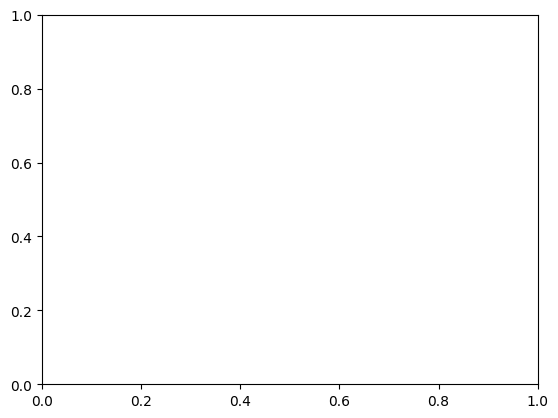

In [ ]:
from sklearn.ensemble import   StackingClassifier #
from sklearn.svm import SVC #
from sklearn.linear_model import LogisticRegression #
from sklearn.tree import DecisionTreeClassifier
estimators = [('SVC', SVC(max_iter=10)),
              ('LogReg', LogisticRegression()),
              ('Tree',DecisionTreeClassifier())]
clf=StackingClassifier(estimators=estimators)
flip_level=0.2
Div_plate(clf,flip_level)

In [ ]:
clf.final_estimator_.coef_

Посмотрите на коэффициенты логистической регрессии финальной модели и скажите, результаты какого классификатора из ансамбля более важны?

Пробуйте самостоятельно другие данные, другие модели, другие параметры моделей.